In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import matplotlib
import numpy as np
from tqdm import trange
from sklearn.datasets import make_moons

from matplotlib import pyplot as plt

In [64]:
class TwoMoonsDataset(torch.utils.data.Dataset):
    """
    Dataset where targets only depend on one of the input dimensions
    We want to ensure we capture uncertainty when deviating even in the insensitive direction
    """
    def __init__(self, N=200, noise=0.2, split='train') -> None:
        super().__init__()
        if split=='train':
            random_state = 1
        elif split == 'val':
            random_state = 2
        else:
            random_state = 3
        X,y = make_moons(n_samples=N, shuffle=True, noise=noise, random_state=random_state)
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

In [67]:
# DNN mapping 2d input to 1d distribution parameter
model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Bernoulli(logits=theta)

In [102]:
dataset = TwoMoonsDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
t = trange(100)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)
        mean_loss = loss.mean()

        regularization = torch.sum(torch.cat([torch.norm(p)**2 for p in model.parameters()])) / 1e3

        total_loss = mean_loss + regularization
        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

SyntaxError: invalid syntax (3032657799.py, line 20)

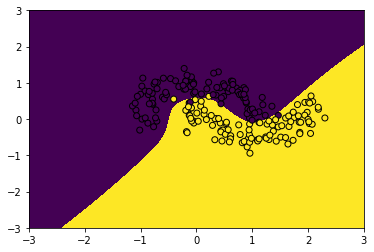

In [69]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=0., vmax=1.)
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=0., vmax=1, edgecolors='k')

In [83]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304
})

In [88]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


100%|██████████| 200/200 [00:00<00:00, 340.28it/s]


In [89]:
val_dataset = TwoMoonsDataset(split='val')
unc_model.calibrate(val_dataset, 0.95)

100%|██████████| 20/20 [00:00<00:00, 146.95it/s]


In [86]:
unc_model.projector.eigs[-50:]

tensor([2.4175e-05, 2.5332e-05, 2.5662e-05, 2.5832e-05, 2.8597e-05, 3.1530e-05,
        3.1605e-05, 4.0707e-05, 4.2372e-05, 5.9209e-05, 6.4187e-05, 9.3872e-05,
        1.0189e-04, 1.4993e-04, 2.0773e-04, 3.2313e-04, 3.4047e-04, 4.4645e-04,
        6.4747e-04, 7.2109e-04, 7.2128e-04, 1.2004e-03, 1.8328e-03, 2.5128e-03,
        2.6983e-03, 5.1219e-03, 5.4621e-03, 7.8723e-03, 8.5196e-03, 1.0964e-02,
        1.9473e-02, 2.5363e-02, 3.6491e-02, 5.5233e-02, 7.2012e-02, 1.4826e-01,
        2.0157e-01, 3.3582e-01, 6.0180e-01, 6.2120e-01, 1.1029e+00, 1.4111e+00,
        2.8301e+00, 5.9664e+00, 1.0638e+01, 1.5374e+01, 5.3368e+01, 1.2981e+02,
        4.9105e+02, 1.3333e+03])

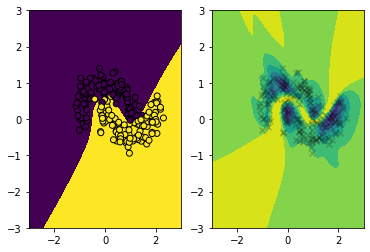

In [100]:
yhat, sig = unc_model(xx_tensor, Meps=100.)
yhat = yhat[:,0].detach().cpu().numpy()
sig = sig.detach().cpu().numpy()

fig, axes = plt.subplots(1,2)
axes[0].contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=0., vmax=1.)
axes[0].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=0, vmax=1, edgecolors='k')
axes[1].contourf(X1,X2,sig.reshape(X1.shape)) #, levels=[0., 0.25, 0.5, 0.75, 1., 1.25, 1.5], extend="both")
axes[1].scatter(dataset.X[:,0], dataset.X[:,1], marker='x', facecolor='k', alpha=0.2)